In [1]:
import ee
import geemap
import xarray as xr
!pip install xee
import xee

In [2]:
ee.Authenticate()
ee.Initialize(
    project = 'gee-climate-aridity-tjk',
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)

In [3]:
#타지키스탄 구역 Square로 지정
map = geemap.Map(basemap = 'SATELLITE', ee_initialize=False)
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [4]:
roi = map.draw_last_feature.geometry()
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          59.57886,
                          35.173309
                        ],
                        [
                          59.57886,
                          43.960751
                        ],
                        [
                          80.493149,
                          43.960751
                        ],
                        [
                          80.493149,
                          35.173309
                        ],
                        [
                          59.57886,
                          35.173309
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [5]:
time_start = ee.Date('2005')
time_end = ee.Date('2025')
time_dif = time_end.difference(time_start, 'year').round()
time_list = ee.List.sequence(0, ee.Number(time_dif).subtract(1)).map(
    lambda x: time_start.advance(x, 'year')
)

def annual(date, col):
  start_date = ee.Date(date)
  end_date = start_date.advance(1, 'year')
  img_sum = col.filterDate(start_date, end_date).sum()
  return img_sum.set('system:time_start', start_date.millis())

gpm = (
    ee.ImageCollection("NASA/GPM_L3/IMERG_MONTHLY_V07")
    .filterDate(time_start, time_end)
    .select('precipitation')
    .map(lambda x: x.multiply(730).copyProperties(x, ['system:time_start']))
)

mod = (
    ee.ImageCollection("MODIS/061/MOD16A2GF")
    .filterDate(time_start, time_end)
    .select('PET')
    .map(lambda x: x.multiply(0.1).copyProperties(x, ['system:time_start']))
)

gpm_annual = ee.ImageCollection(time_list.map(lambda x: annual(x, gpm)))
mod_annual = ee.ImageCollection(time_list.map(lambda x: annual(x, mod)))

collection = gpm_annual.combine(mod_annual)

ds = xr.open_dataset(
    collection,
    engine ='ee',
    crs = 'EPSG:4326', #WGS84
    scale = 0.1,
    geometry = roi
)

In [6]:
ds = ds.sortby('time') * 1

In [7]:
ds

<xarray.Dataset> Size: 3MB
Dimensions:        (time: 20, lon: 209, lat: 88)
Coordinates:
  * time           (time) datetime64[ns] 160B 2005-01-01 ... 2024-01-01
  * lon            (lon) float64 2kB 59.63 59.73 59.83 ... 80.23 80.33 80.43
  * lat            (lat) float64 704B 35.22 35.32 35.42 ... 43.72 43.82 43.92
Data variables:
    precipitation  (time, lon, lat) float32 1MB 209.5 220.5 ... 438.0 422.7
    PET            (time, lon, lat) float32 1MB 2.16e+03 2.038e+03 ... 1.802e+03
Attributes:
    crs:      EPSG:4326

In [8]:
aridity = ds.precipitation / ds.PET #PET: Potential evapotranspiration (증발산: 증산+발산, 토양 표면의 수분이 증발하고 식물 잎에서 증산 작용으로 물이 빠져나가는 과정을 합쳐서 부르는 용어로, 지구 표면의 물이 대기로 이동하는 핵심적인 수문 순환 과정 중 하나)

In [9]:
import matplotlib.pyplot as plt

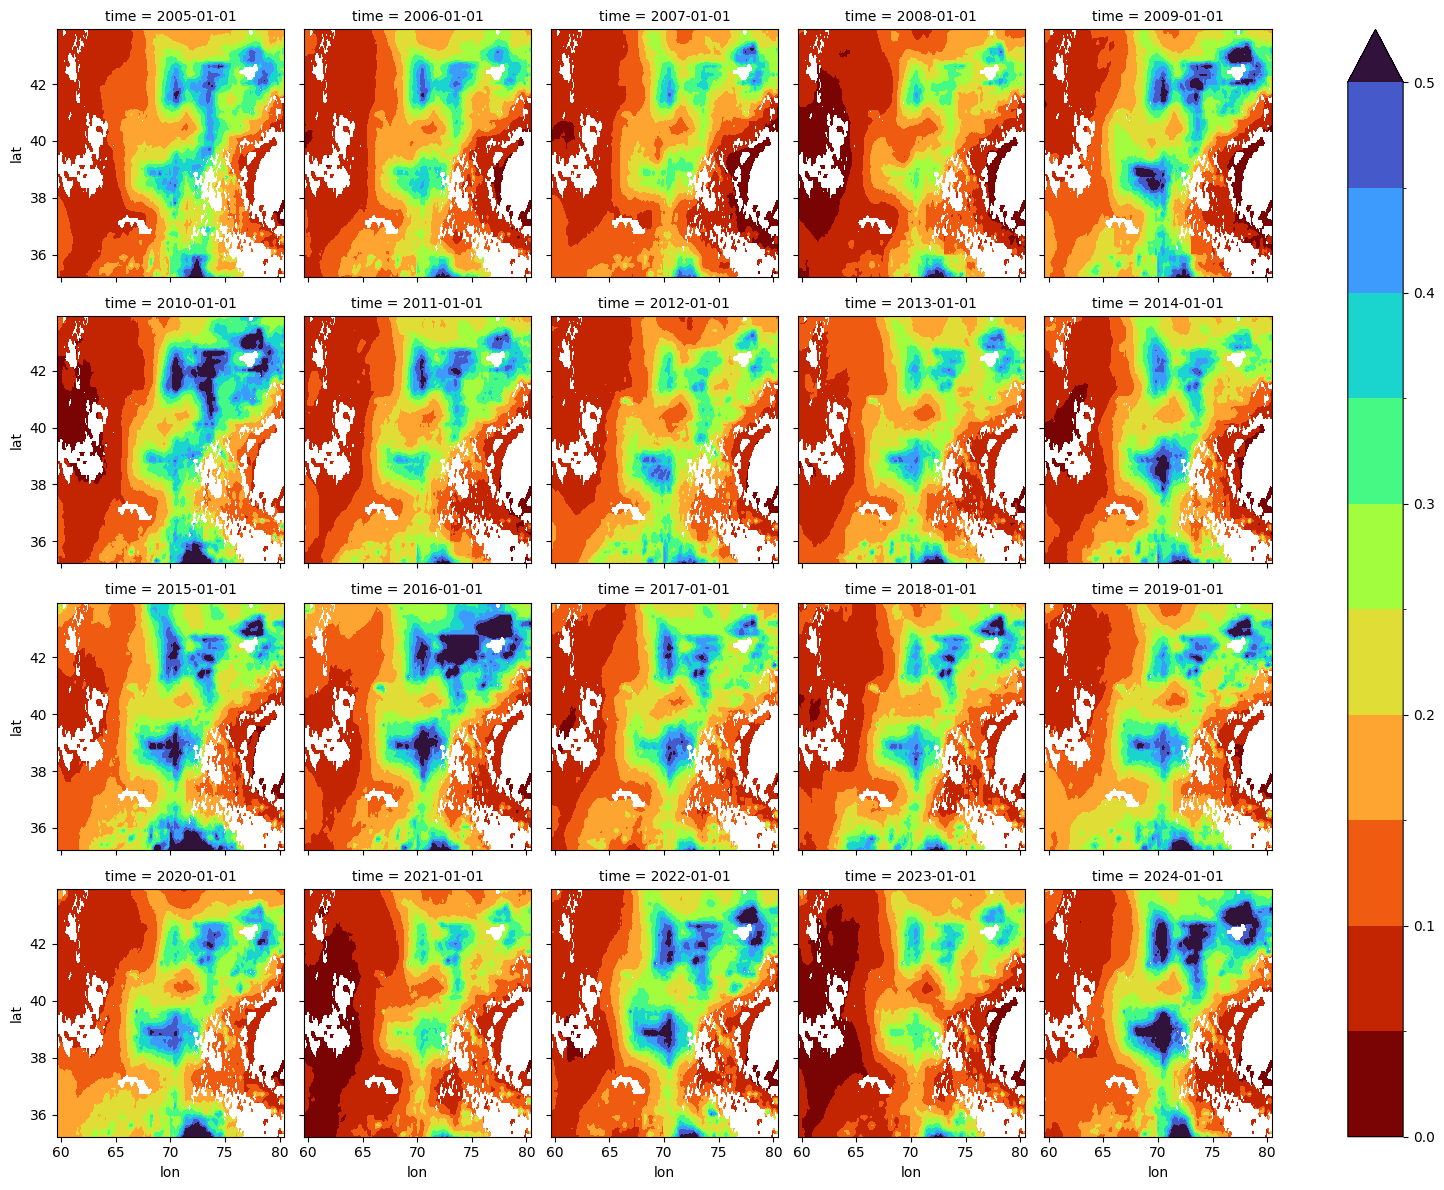

In [10]:
aridity.plot.contourf(
    x = 'lon',
    y = 'lat',
    col = 'time',
    col_wrap = 5,
    robust = True, #Increase contrast for outputs (대비 상향 시켜주는 것)
    levels = 10, #범위를 몇 개로 나눌지에 대한 것
    cmap = 'turbo_r'
)

plt.savefig('aridity_map.png', dpi = 360, bbox_inches = 'tight')

In [11]:
import numpy as np

In [12]:
#Index of Aridity (adopted from UNEP)에 기반한 Classification
aridity_map = xr.where(aridity < 0.05, 1,
                       xr.where(
                           aridity < 0.2, 2,
                           xr.where(
                               aridity < 0.5, 3,
                               xr.where(
                                   aridity < 1, 4, np.nan
                               )
                           )
                       ))

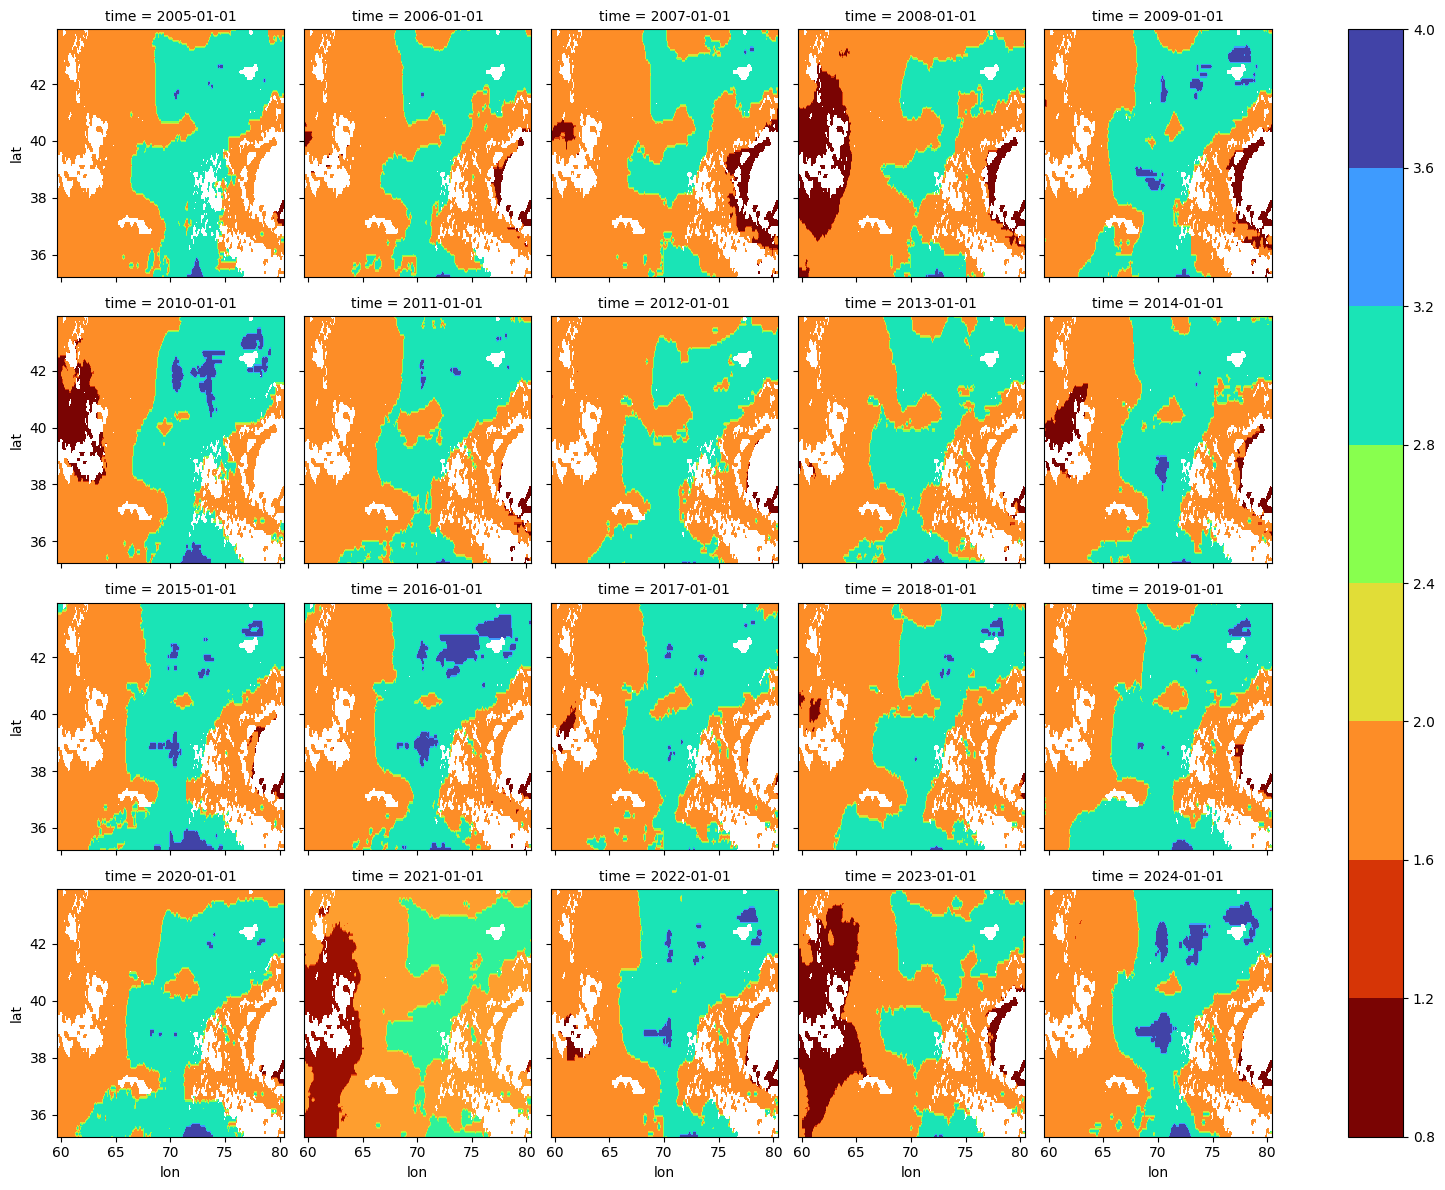

In [13]:
aridity_map.plot.contourf(
    x = 'lon',
    y = 'lat',
    col = 'time',
    col_wrap = 5,
    cmap = 'turbo_r'
)

plt.savefig('aridity_map_classified.png', dpi = 360, bbox_inches = 'tight')